In [1]:
from operator import truediv

from anyio.lowlevel import checkpoint
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
load_dotenv()

True

In [3]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [4]:
llm = ChatOpenAI()


def chat_node(state: ChatState):

    # take user query from state
    messages = state['messages']

    # send to llm
    response = llm.invoke(messages)

    # response store state
    return {'messages': [response]}

In [5]:
checkpointer = MemorySaver()

graph = StateGraph(ChatState)

# add nodes
graph.add_node('chat_node', chat_node)

graph.add_edge(START, 'chat_node')
graph.add_edge('chat_node', END)

chatbot = graph.compile(checkpointer=checkpointer)

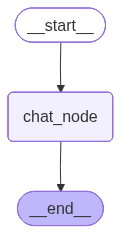

In [6]:
chatbot

In [7]:
initial_state = {
    'messages': [HumanMessage(content='What is the capital of india')]
}

In [8]:
thread_id = '1'

while True:
    user_message = input('Type a message: ')
    print('user message:', user_message)

    if user_message.strip().lower() in ['exit', 'quit', 'bye']:
        break

    config = {'configurable': {'thread_id': thread_id}}
    response = chatbot.invoke({'messages': [HumanMessage(content=user_message)]}, config=config)
    print('AI:', response['messages'][-1].content)

user message: Hi my name is Ravi, whats yours?
AI: Hello Ravi, I am an AI digital assistant. How can I assist you today?
user message: Sure , can you generate pictures ?
AI: I can't generate pictures, but I can provide you with links to websites where you can find free images or help you with any other questions you have. Let me know how I can assist you!
user message: What is my name ?

AI: Your name is Ravi.
user message: what 2 plus 2 ?
AI: 2 + 2 equals 4.
user message: multiply the result with 4 now 
AI: Sure, the result of 2 + 2 is 4. Multiplying 4 by 4 gives us 16.
user message: exit


In [9]:
    chatbot.get_state(config=config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi my name is Ravi, whats yours?', additional_kwargs={}, response_metadata={}, id='dba50815-dc4f-43c8-9976-c56ed959939b'), AIMessage(content='Hello Ravi, I am an AI digital assistant. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 17, 'total_tokens': 35, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CLdGuYv8U1kSasuQoMqAKU5R5UqUo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--fd6c5e84-4e93-40b1-9502-0fce172d3782-0', usage_metadata={'input_tokens': 17, 'output_tokens': 18, 'total_tokens': 35, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details